In [41]:
import tensorflow as tf
import numpy as np


In [2]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

--2022-07-17 00:52:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.003s  

2022-07-17 00:52:05 (56.9 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [3]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [4]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


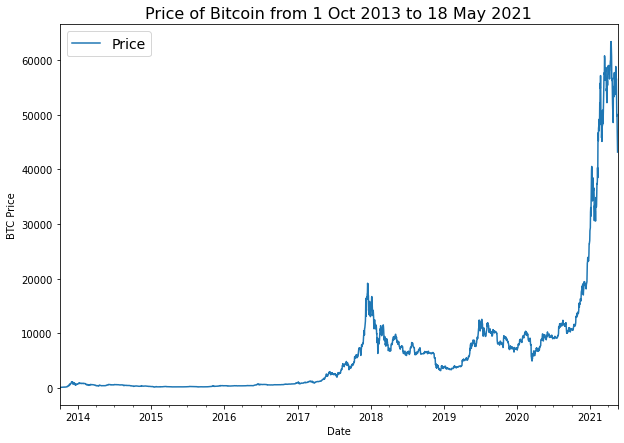

In [5]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

In [29]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

# prices = prices[:20]

In [30]:
prices_ds = tf.data.Dataset.from_tensor_slices(prices)

In [31]:
def windowed_dataset(series, window_size, batch_size):
 series = tf.expand_dims(series, axis=-1)
 ds = tf.data.Dataset.from_tensor_slices(series)
 ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
 ds = ds.flat_map(lambda w: w.batch(window_size + 1))
# ds = ds.shuffle(shuffle_buffer)
 ds = ds.map(lambda w: (w[:-1], w[1:]))
 return ds.batch(batch_size).prefetch(1)

In [32]:
windowed_ds = windowed_dataset(prices, 7, 256)

In [42]:
# for window in windowed_ds:
#  print([item.numpy() for item in window])

In [34]:
model = tf.keras.models.Sequential([
 tf.keras.layers.Conv1D(filters=60, kernel_size=5,
 strides=1, padding='causal',
 activation='relu',
 input_shape=[None, 1]),
 tf.keras.layers.LSTM(60, return_sequences=True),
 tf.keras.layers.LSTM(60, return_sequences=True),
 tf.keras.layers.Dense(30, activation='relu'),
 tf.keras.layers.Dense(10, activation='relu'),
 tf.keras.layers.Dense(1),
 tf.keras.layers.Lambda(lambda x: x * 400)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 60)          360       
                                                                 
 lstm_4 (LSTM)               (None, None, 60)          29040     
                                                                 
 lstm_5 (LSTM)               (None, None, 60)          29040     
                                                                 
 dense_6 (Dense)             (None, None, 30)          1830      
                                                                 
 dense_7 (Dense)             (None, None, 10)          310       
                                                                 
 dense_8 (Dense)             (None, None, 1)           11        
                                                                 
 lambda_2 (Lambda)           (None, None, 1)          

In [35]:
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
 optimizer=optimizer,
 metrics=['mae'])
history = model.fit(windowed_ds,epochs=50)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


11/11 [==============================] - 4s 59ms/step - loss: 6425.6548 - mae: 6426.1543
Epoch 2/50
11/11 [==============================] - 1s 64ms/step - loss: 6100.2949 - mae: 6100.7949
Epoch 3/50
11/11 [==============================] - 1s 67ms/step - loss: 5942.9883 - mae: 5943.4883
Epoch 4/50
11/11 [==============================] - 1s 62ms/step - loss: 5996.5972 - mae: 5997.0972
Epoch 5/50
11/11 [==============================] - 1s 71ms/step - loss: 6018.5713 - mae: 6019.0708
Epoch 6/50
11/11 [==============================] - 1s 62ms/step - loss: 6033.9868 - mae: 6034.4868
Epoch 7/50
11/11 [==============================] - 1s 64ms/step - loss: 5994.2505 - mae: 5994.7505
Epoch 8/50
11/11 [==============================] - 1s 58ms/step - loss: 6021.4272 - mae: 6021.9272
Epoch 9/50
11/11 [==============================] - 1s 69ms/step - loss: 5991.1582 - mae: 5991.6587
Epoch 10/50
11/11 [==============================] - 1s 65ms/step - loss: 5994.3560 - mae: 5994.8564
Epoch 11/5

Try different way

In [36]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [37]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [39]:
WINDOW_SIZE = 7
HORIZON = 1

In [43]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [44]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [45]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [62]:
model = tf.keras.models.Sequential([
 tf.keras.layers.Conv1D(filters=60, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
 # tf.keras.layers.LSTM(60, return_sequences=True, input_shape=[None, 1]),
 # tf.keras.layers.LSTM(60, return_sequences=True),
 # tf.keras.layers.Dense(30, activation='relu'),
 tf.keras.layers.Dense(10, activation='relu'),
 tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, None, 60)          360       
                                                                 
 dense_30 (Dense)            (None, None, 10)          610       
                                                                 
 dense_31 (Dense)            (None, None, 1)           11        
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())
history = model.fit(train_windows, train_labels, epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels))

Epoch 1/100
18/18 [==============================] - 1s 12ms/step - loss: 2579.3960 - val_loss: 12123.4814
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 1326.9598 - val_loss: 6686.1714
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 992.3696 - val_loss: 5473.7715
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 802.3215 - val_loss: 4495.2202
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 644.1910 - val_loss: 3476.7964
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 491.0446 - val_loss: 2630.3174
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 391.0780 - val_loss: 2134.9773
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 329.7365 - val_loss: 1813.4469
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 286.4627 - val_loss: 1614.0591
Epoch 10/100
18/18 [==============================] - 0s 6ms

In [54]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels))

Epoch 1/100
18/18 [==============================] - 1s 14ms/step - loss: 780.3469 - val_loss: 2279.5828
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 247.6765 - val_loss: 1005.9864
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 188.4107 - val_loss: 923.2859
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 169.4334 - val_loss: 900.5932
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 165.0900 - val_loss: 895.2405
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 158.5206 - val_loss: 855.1868
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 151.3568 - val_loss: 840.9290
Epoch 8/100
18/18 [==============================] - 0s 5ms/step - loss: 145.2560 - val_loss: 803.6005
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 144.3546 - val_loss: 799.5592
Epoch 10/100
18/18 [==============================] - 0s 5ms/step - lo